In [5]:
#!/usr/bin/env python3
# Train a font classifier with ResNet-18 on MPS/CUDA/CPU
# Folder layout:
# data/
#   Inter/
#     *.png
#   Roboto/
#     *.png
# ...

import os, json, math, time, random, copy
from pathlib import Path
from collections import Counter
from contextlib import nullcontext

import platform
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, models, transforms

# ----------------------------
# Repro / Threads (macOS friendly)
# ----------------------------
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
try:
    torch.set_num_threads(1)
    torch.set_num_interop_threads(1)
    print("Threads set: num_threads=1, interop_threads=1")
except Exception as e:
    print(f"Could not set threads: {e}")

# ----------------------------
# Config
# ----------------------------
DATA_DIR      = "data"                # dataset root (class-per-folder)
OUT_DIR       = "runs/font_resnet"
BATCH_SIZE    = 32                    # lower if OOM (e.g., 16)
EPOCHS        = 12                    # 3 warmup + 9 fine-tune
WARMUP_E      = 3                     # epochs with frozen backbone
VAL_SPLIT     = 0.15
LEARNING_RATE = 3e-4
WEIGHT_DECAY  = 1e-4
NUM_WORKERS   = 0                     # macOS safer as 0..2
PIN_MEMORY    = False
IMG_SIZE      = 320   # started at 244 
LOG_EVERY     = 50                    # batches

# ----------------------------
# Device (Apple Silicon friendly)
# ----------------------------
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(f"Using device: {device} | mps_available={torch.backends.mps.is_available()} | cuda={torch.cuda.is_available()}")
print("platform.machine:", platform.machine())

# ----------------------------
# Transforms (typography-friendly)
# ----------------------------
train_tfms = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),              # ensure 3-ch
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.8, 1.0), antialias=True),
    transforms.RandomAffine(degrees=2, translate=(0.02, 0.02), shear=(-2, 2), fill=255),
    transforms.RandomApply([transforms.GaussianBlur(kernel_size=3)], p=0.15),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225]),
])

val_tfms = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize(256, antialias=True),
    transforms.CenterCrop(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225]),
])

# ----------------------------
# Dataset / Split
# ----------------------------
base_ds     = datasets.ImageFolder(DATA_DIR)  # no transform here
num_classes = len(base_ds.classes)
assert num_classes > 1, "Need at least 2 classes under DATA_DIR"
print("Classes:", base_ds.classes)

Path(OUT_DIR).mkdir(parents=True, exist_ok=True)
with open(Path(OUT_DIR) / "classes.json", "w") as f:
    json.dump(base_ds.classes, f)

n_total = len(base_ds)
assert n_total > 0, "No images found under DATA_DIR"
n_val   = int(math.ceil(n_total * VAL_SPLIT))
n_train = n_total - n_val

g = torch.Generator().manual_seed(SEED)
perm = torch.randperm(n_total, generator=g).tolist()
train_idx, val_idx = perm[:n_train], perm[n_train:]

train_base = copy.deepcopy(base_ds); train_base.transform = train_tfms
val_base   = copy.deepcopy(base_ds); val_base.transform   = val_tfms

train_ds = Subset(train_base, train_idx)
val_ds   = Subset(val_base,   val_idx)

train_loader = DataLoader(
    train_ds, batch_size=BATCH_SIZE, shuffle=True,
    num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY, persistent_workers=False
)
val_loader = DataLoader(
    val_ds, batch_size=BATCH_SIZE, shuffle=False,
    num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY, persistent_workers=False
)
print(f"Samples | train: {len(train_ds)}  val: {len(val_ds)}")
print(f"Steps/epoch | train: {len(train_loader)}  val: {len(val_loader)}")

# ----------------------------
# Model (ResNet-18) + head
# ----------------------------
model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
in_features = model.fc.in_features
model.fc = nn.Linear(in_features, num_classes)
model.to(device)

# ----------------------------
# Optimizer / Scheduler / Loss
# ----------------------------
criterion = nn.CrossEntropyLoss().to(device)

def make_optimizer(trainable_params, lr=LEARNING_RATE):
    return optim.AdamW(trainable_params, lr=lr, weight_decay=WEIGHT_DECAY)

# ----------------------------
# Freeze/Unfreeze helpers (ResNet: head is "fc")
# ----------------------------
def freeze_backbone_keep_head(m: nn.Module):
    for p in m.parameters():
        p.requires_grad = False
    for p in m.fc.parameters():
        p.requires_grad = True

def unfreeze_all(m: nn.Module):
    for p in m.parameters():
        p.requires_grad = True

# Warmup: freeze backbone, train only head
freeze_backbone_keep_head(model)
optimizer = make_optimizer(filter(lambda p: p.requires_grad, model.parameters()))
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)

# ----------------------------
# AMP (CUDA only) and autocast context
# ----------------------------
use_cuda_amp = (device.type == "cuda")
scaler = torch.amp.GradScaler('cuda', enabled=use_cuda_amp)
def autocast_ctx():
    return torch.amp.autocast('cuda', dtype=torch.float16) if use_cuda_amp else nullcontext()

# ----------------------------
# Train / Eval loops
# ----------------------------
best_val_acc = 0.0
best_ckpt = Path(OUT_DIR) / "best.ckpt.pt"

def run_epoch(loader, train=True, log_every=LOG_EVERY, max_grad_norm=1.0):
    model.train(mode=train)
    running_loss, correct, total = 0.0, 0, 0

    outer_ctx = nullcontext() if train else torch.no_grad()
    with outer_ctx:
        for i, (images, targets) in enumerate(loader):
            images = images.to(device, non_blocking=True).contiguous()
            targets = targets.to(device, non_blocking=True)

            with torch.set_grad_enabled(train):
                with autocast_ctx():
                    outputs = model(images)
                    loss = criterion(outputs, targets)

                if train:
                    optimizer.zero_grad(set_to_none=True)
                    if use_cuda_amp:
                        scaler.scale(loss).backward()
                        scaler.unscale_(optimizer)
                        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
                        scaler.step(optimizer)
                        scaler.update()
                    else:
                        loss.backward()
                        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
                        optimizer.step()

            running_loss += loss.item() * images.size(0)
            preds = outputs.argmax(1)
            correct += (preds == targets).sum().item()
            total   += targets.size(0)

            if log_every and ((i + 1) % log_every == 0):
                avg = running_loss / max(1, total)
                print(f"  [{i+1}/{len(loader)}] running_avg_loss={avg:.4f}")

    avg_loss = running_loss / total if total else 0.0
    acc = correct / total if total else 0.0
    return avg_loss, acc

# ----------------------------
# Train
# ----------------------------
for epoch in range(EPOCHS):
    t0 = time.time()

    # Unfreeze at the start of epoch WARMUP_E
    if epoch == WARMUP_E:
        print(f"Unfreezing all layers at epoch {epoch}...")
        unfreeze_all(model)
        optimizer = make_optimizer(model.parameters(), lr=LEARNING_RATE * 0.5)  # gentle LR after unfreeze
        remaining = max(1, EPOCHS - epoch)
        scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=remaining)

    train_loss, train_acc = run_epoch(train_loader, train=True)
    val_loss, val_acc     = run_epoch(val_loader,   train=False)
    scheduler.step()  # called AFTER optimizer.step() happened inside the epoch

    dt = time.time() - t0
    print(f"Epoch {epoch+1:02d}/{EPOCHS} | "
          f"train_loss {train_loss:.4f} acc {train_acc:.3f} | "
          f"val_loss {val_loss:.4f} acc {val_acc:.3f} | {dt:.1f}s")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save({
            "model_state": model.state_dict(),
            "classes": base_ds.classes,
            "val_acc": val_acc
        }, best_ckpt)
        print(f"  ✅ Saved new best to {best_ckpt} (val_acc={val_acc:.3f})")

print(f"Best val acc: {best_val_acc:.3f}")

# ----------------------------
# Per-class accuracies on val set
# ----------------------------
model.eval()
correct_per, total_per = Counter(), Counter()
with torch.no_grad():
    for imgs, t in val_loader:
        imgs = imgs.to(device).contiguous()
        o = model(imgs).argmax(1).cpu()
        for ti, pi in zip(t, o):
            total_per[int(ti)] += 1
            correct_per[int(ti)] += int(pi == ti)

per_class_acc = { base_ds.classes[k]: (correct_per[k] / total_per[k] if total_per[k] > 0 else 0.0)
                  for k in total_per }
print("Per-class accuracy:", per_class_acc)


Could not set threads: Error: cannot set number of interop threads after parallel work has started or set_num_interop_threads called
Using device: mps | mps_available=True | cuda=False
platform.machine: arm64
Classes: ['Inter', 'Lato', 'Merriweather', 'Montserrat', 'Nunito', 'Open_Sans', 'Oswald', 'Playfair_Display', 'Poppins', 'Raleway', 'Roboto', 'Roboto_Condensed', 'Roboto_Mono', 'Source_Sans_Pro', 'Ubuntu']
Samples | train: 6375  val: 1125
Steps/epoch | train: 200  val: 36


2.6%

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /Users/davidferris/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100.0%


  [50/200] running_avg_loss=2.6811
  [100/200] running_avg_loss=2.6369
  [150/200] running_avg_loss=2.5823
  [200/200] running_avg_loss=2.5343
Epoch 01/12 | train_loss 2.5343 acc 0.197 | val_loss 2.6572 acc 0.154 | 57.8s
  ✅ Saved new best to runs/font_resnet/best.ckpt.pt (val_acc=0.154)
  [50/200] running_avg_loss=2.3510
  [100/200] running_avg_loss=2.3204
  [150/200] running_avg_loss=2.2852
  [200/200] running_avg_loss=2.2586
Epoch 02/12 | train_loss 2.2586 acc 0.315 | val_loss 2.8527 acc 0.133 | 57.0s
  [50/200] running_avg_loss=2.1297
  [100/200] running_avg_loss=2.1337
  [150/200] running_avg_loss=2.1176
  [200/200] running_avg_loss=2.1047
Epoch 03/12 | train_loss 2.1047 acc 0.375 | val_loss 2.4329 acc 0.279 | 58.7s
  ✅ Saved new best to runs/font_resnet/best.ckpt.pt (val_acc=0.279)
Unfreezing all layers at epoch 3...
  [50/200] running_avg_loss=1.3635
  [100/200] running_avg_loss=1.2321
  [150/200] running_avg_loss=1.1469
  [200/200] running_avg_loss=1.0937
Epoch 04/12 | train_lo

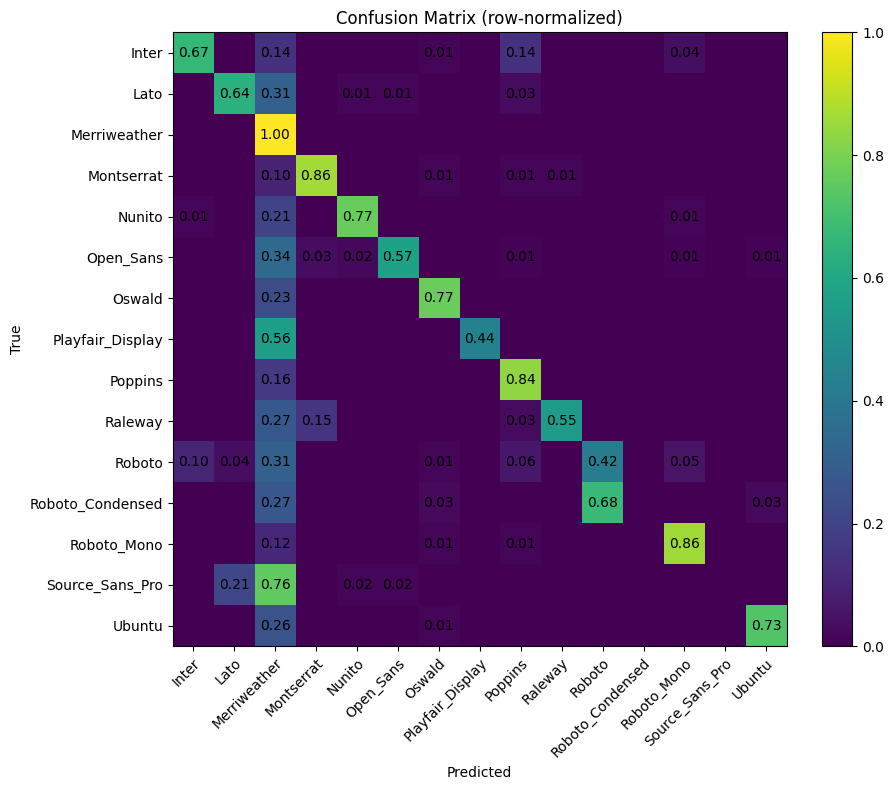

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# --- collect preds/targets ---
model.eval()
all_t, all_p = [], []
with torch.no_grad():
    for imgs, t in val_loader:
        preds = model(imgs.to(device)).argmax(1).cpu().numpy()
        all_p.append(preds)
        all_t.append(t.numpy())
all_p = np.concatenate(all_p)
all_t = np.concatenate(all_t)

classes = base_ds.classes  # or full_ds.classes
labels  = np.arange(len(classes))

# --- confusion matrix ---
cm = confusion_matrix(all_t, all_p, labels=labels)

# toggle normalization
normalize = True
if normalize:
    with np.errstate(invalid="ignore", divide="ignore"):
        cm_plot = cm.astype(float) / cm.sum(axis=1, keepdims=True)
    cm_plot = np.nan_to_num(cm_plot)
    fmt = ".2f"
    title = "Confusion Matrix (row-normalized)"
else:
    cm_plot = cm
    fmt = "d"
    title = "Confusion Matrix (counts)"

# --- plot ---
fig, ax = plt.subplots(figsize=(10, 8))
im = ax.imshow(cm_plot, interpolation="nearest")  # default colormap
fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

ax.set(
    xticks=np.arange(len(classes)),
    yticks=np.arange(len(classes)),
    xticklabels=classes,
    yticklabels=classes,
    xlabel="Predicted",
    ylabel="True",
    title=title,
)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# annotate cells
thresh = cm_plot.max() / 2.0
for i in range(cm_plot.shape[0]):
    for j in range(cm_plot.shape[1]):
        val = cm_plot[i, j]
        text = f"{val:{fmt}}"
        # skip tiny normalized values to reduce clutter
        if normalize and val < 0.005:
            text = ""
        ax.text(j, i, text, ha="center", va="center")

plt.tight_layout()
plt.show()

